## Crypto

### 1. Read Data

In [7]:
import os, glob
from pathlib import Path
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [8]:
if os.path.isfile("../data/interim/crypto.pkl"): # if data is already read
    data = pickle.load(open('../data/interim/crypto.pkl', 'rb'))
else:
    REL_PATH = "../data/raw/cryptocurrencypricehistory/*.csv" # working with .csv files
    # two kind of files: datasets and price (classification based on its inner data and structure)

    data = {i: list() for i in ['datasets', 'price']} # init data structure
    
    for file in glob.glob(REL_PATH):
        df = pd.read_csv(file)
        filename = Path(file).stem
        
        if filename.split('_')[-1] == 'price':
            df["Crypto"] = [filename] * df.shape[0]
            data['price'].append(df)
        else:
             data['datasets'].append(df)
                
        pickle.dump(data, open('../data/interim/crypto.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL) # save read data


In [9]:
data['price'][0].info()
data['price'][0].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        85 non-null     object 
 1   Open        85 non-null     float64
 2   High        85 non-null     float64
 3   Low         85 non-null     float64
 4   Close       85 non-null     float64
 5   Volume      85 non-null     object 
 6   Market Cap  85 non-null     object 
 7   Crypto      85 non-null     object 
dtypes: float64(4), object(4)
memory usage: 5.4+ KB


,Open,High,Low,Close
count,85.000000,85.000000,85.000000,85.000000
mean,0.501695,0.537700,0.455827,0.502194
std,0.254753,0.267625,0.232656,0.256240
min,0.157961,0.176099,0.147933,0.158688
25%,0.286164,0.304476,0.262736,0.284565
50%,0.413371,0.437340,0.388231,0.410757
75%,0.722169,0.775863,0.658006,0.721535
max,1.040000,1.100000,0.998241,1.050000


In [10]:
def asdf(df):
    df.Date = pd.to_datetime(df.Date, format = "%b %d, %Y")
    df.loc[df["Market Cap"] == '-', "Market Cap"] = '0'
    df.loc[df["Volume"] == '-', "Volume"] = '0'
    df.Volume = df.Volume.apply(lambda x: x.replace(',','') if type(x) is str else x).astype('int64')
    df["Market Cap"] = df["Market Cap"].apply(lambda x: x.replace(',','') if type(x) is str else x).astype('int64')
    return df

data['price'] = list(map(asdf, data['price']))
data['price'][0].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        85 non-null     datetime64[ns]
 1   Open        85 non-null     float64       
 2   High        85 non-null     float64       
 3   Low         85 non-null     float64       
 4   Close       85 non-null     float64       
 5   Volume      85 non-null     int64         
 6   Market Cap  85 non-null     int64         
 7   Crypto      85 non-null     object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.4+ KB


In [11]:
dff = pd.concat(data['price'], axis=0)

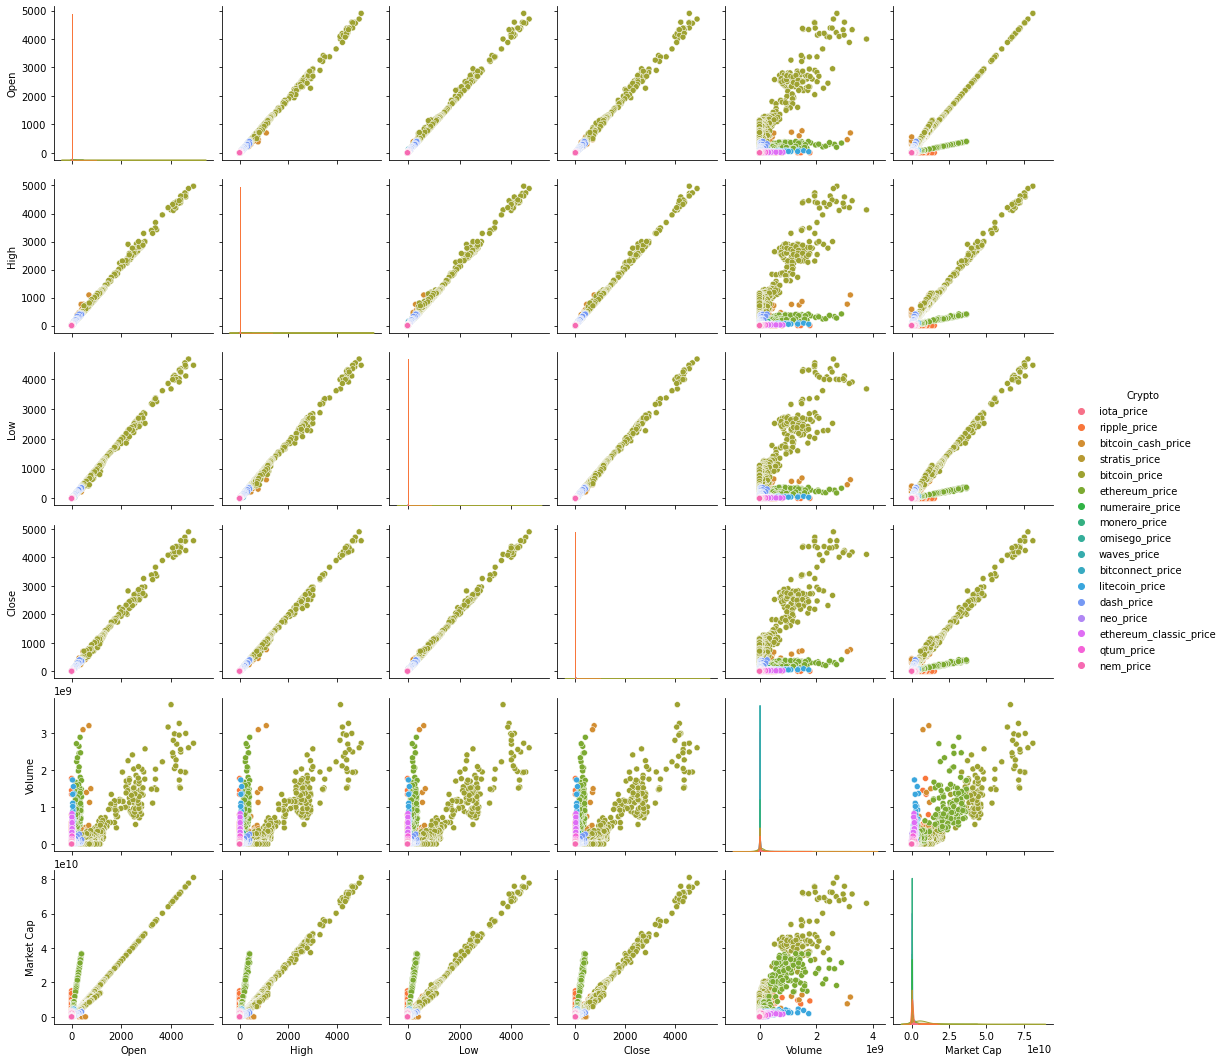

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(dff, hue="Crypto")

In [13]:
data['datasets'][0].info()
data['datasets'][0].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1584 non-null   object 
 1   btc_market_price                                     1584 non-null   float64
 2   btc_total_bitcoins                                   1584 non-null   float64
 3   btc_market_cap                                       1584 non-null   float64
 4   btc_trade_volume                                     1106 non-null   float64
 5   btc_blocks_size                                      1584 non-null   float64
 6   btc_avg_block_size                                   1584 non-null   float64
 7   btc_n_orphaned_blocks                                1584 non-null   float64
 8   btc_n_transactions_per_block                         1584 non-null  

,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,btc_hash_rate,...,btc_cost_per_transaction_percent,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd
count,1584.000000,1.584000e+03,1.584000e+03,1.106000e+03,1584.000000,1584.000000,1584.000000,1584.000000,1584.000000,1.584000e+03,...,1.584000e+03,1584.000000,1584.000000,1584.000000,1.584000e+03,1584.000000,1584.000000,1.584000e+03,1.584000e+03,1.584000e+03
mean,334.095935,9.858289e+06,5.045619e+09,7.163810e+06,25575.157921,0.275350,0.332702,524.398118,6.325609,5.922701e+05,...,1.936839e+03,9.991641,146279.104167,79702.557449,4.995044e+07,73023.962121,48678.102273,1.341287e+06,1.754802e+05,8.198947e+07
std,609.052564,5.170361e+06,9.932860e+09,1.825481e+07,35584.788312,0.323961,0.803367,624.657294,5.235022,1.311404e+06,...,4.483039e+04,12.749557,175945.983749,93616.287421,6.764581e+07,93160.749994,62017.952608,2.349160e+06,2.430975e+05,1.749650e+08
min,0.000000,5.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.897500,5.609512e+06,4.942691e+06,0.000000e+00,10.000000,0.004050,0.000000,12.000000,0.000000,4.656278e-01,...,1.089992e+00,2.015895,2829.000000,2046.750000,3.124270e+05,2046.750000,1539.500000,1.733491e+05,5.297075e+04,4.475075e+04
50%,97.235000,1.111709e+07,1.105880e+09,2.695221e+05,7364.000000,0.133423,0.000000,287.500000,7.400000,7.760397e+01,...,2.571138e+00,6.592404,53019.000000,49466.000000,1.725231e+07,24052.500000,22898.000000,8.295208e+05,1.493515e+05,1.516898e+07
75%,446.337500,1.435121e+07,6.437710e+09,6.763820e+06,38520.750000,0.446481,0.000000,792.000000,9.316667,3.738849e+05,...,6.787051e+00,10.758279,237152.500000,115646.250000,7.468435e+07,108932.750000,61813.500000,1.801741e+06,2.449880e+05,8.279745e+07
max,4748.255000,1.654439e+07,7.851738e+10,1.984916e+08,131365.560971,0.998177,5.000000,2235.977273,47.733333,8.215055e+06,...,1.570000e+06,90.202095,687290.000000,367710.000000,2.520994e+08,354151.000000,256495.000000,4.599222e+07,5.313161e+06,1.422580e+09
